In [1]:
import argparse
import sys
import os
import torch
import os
import random
import utils
import data_utils
import json
import cbm
import plots
def parse_args():
    parser = argparse.ArgumentParser(description='Settings for creating CBM')
    # parser.add_argument('--batch_size', default=64, type=int)
    # parser.add_argument('--epochs', default=30, type=int)
    parser.add_argument('--update_freq', default=1, type=int)
    parser.add_argument('--save_ckpt_freq', default=100, type=int)

    # Model parameters
    parser.add_argument('--model', default='vit_base_patch16_224', type=str, metavar='MODEL',
                        help='Name of model to train')
    parser.add_argument('--tubelet_size', type=int, default= 2)
    parser.add_argument('--input_size', default=224, type=int,
                        help='videos input size')

    parser.add_argument('--fc_drop_rate', type=float, default=0.0, metavar='PCT',
                        help='Dropout rate (default: 0.)')
    parser.add_argument('--drop', type=float, default=0.0, metavar='PCT',
                        help='Dropout rate (default: 0.)')
    parser.add_argument('--attn_drop_rate', type=float, default=0.0, metavar='PCT',
                        help='Attention dropout rate (default: 0.)')
    parser.add_argument('--drop_path', type=float, default=0.1, metavar='PCT',
                        help='Drop path rate (default: 0.1)')

    parser.add_argument('--disable_eval_during_finetuning', action='store_true', default=False)
    parser.add_argument('--model_ema', action='store_true', default=False)
    parser.add_argument('--model_ema_decay', type=float, default=0.9999, help='')
    parser.add_argument('--model_ema_force_cpu', action='store_true', default=False, help='')

    # Optimizer parameters
    parser.add_argument('--opt', default='adamw', type=str, metavar='OPTIMIZER',
                        help='Optimizer (default: "adamw"')
    parser.add_argument('--opt_eps', default=1e-8, type=float, metavar='EPSILON',
                        help='Optimizer Epsilon (default: 1e-8)')
    parser.add_argument('--opt_betas', default=None, type=float, nargs='+', metavar='BETA',
                        help='Optimizer Betas (default: None, use opt default)')
    parser.add_argument('--clip_grad', type=float, default=None, metavar='NORM',
                        help='Clip gradient norm (default: None, no clipping)')
    parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                        help='SGD momentum (default: 0.9)')
    parser.add_argument('--weight_decay', type=float, default=0.05,
                        help='weight decay (default: 0.05)')
    parser.add_argument('--weight_decay_end', type=float, default=None, help="""Final value of the
        weight decay. We use a cosine schedule for WD and using a larger decay by
        the end of training improves performance for ViTs.""")

    parser.add_argument('--lr', type=float, default=1e-3, metavar='LR',
                        help='learning rate (default: 1e-3)')
    parser.add_argument('--layer_decay', type=float, default=0.75)

    parser.add_argument('--warmup_lr', type=float, default=1e-6, metavar='LR',
                        help='warmup learning rate (default: 1e-6)')
    parser.add_argument('--min_lr', type=float, default=1e-6, metavar='LR',
                        help='lower lr bound for cyclic schedulers that hit 0 (1e-5)')

    parser.add_argument('--warmup_epochs', type=int, default=5, metavar='N',
                        help='epochs to warmup LR, if scheduler supports')
    parser.add_argument('--warmup_steps', type=int, default=-1, metavar='N',
                        help='num of steps to warmup LR, will overload warmup_epochs if set > 0')

    # Augmentation parameters
    parser.add_argument('--color_jitter', type=float, default=0.4, metavar='PCT',
                        help='Color jitter factor (default: 0.4)')
    parser.add_argument('--num_sample', type=int, default=1,
                        help='Repeated_aug (default: 2)')
    parser.add_argument('--aa', type=str, default='rand-m7-n4-mstd0.5-inc1', metavar='NAME',
                        help='Use AutoAugment policy. "v0" or "original". " + "(default: rand-m7-n4-mstd0.5-inc1)'),
    parser.add_argument('--smoothing', type=float, default=0.1,
                        help='Label smoothing (default: 0.1)')
    parser.add_argument('--train_interpolation', type=str, default='bicubic',
                        help='Training interpolation (random, bilinear, bicubic default: "bicubic")')

    # Evaluation parameters
    parser.add_argument('--crop_pct', type=float, default=None)
    parser.add_argument('--short_side_size', type=int, default=224)
    parser.add_argument('--test_num_segment', type=int, default=5)
    parser.add_argument('--test_num_crop', type=int, default=3)

    # Random Erase params
    parser.add_argument('--reprob', type=float, default=0.25, metavar='PCT',
                        help='Random erase prob (default: 0.25)')
    parser.add_argument('--remode', type=str, default='pixel',
                        help='Random erase mode (default: "pixel")')
    parser.add_argument('--recount', type=int, default=1,
                        help='Random erase count (default: 1)')
    parser.add_argument('--resplit', action='store_true', default=False,
                        help='Do not random erase first (clean) augmentation split')

    # Mixup params
    parser.add_argument('--mixup', type=float, default=0.0,
                        help='mixup alpha, mixup enabled if > 0.')
    parser.add_argument('--cutmix', type=float, default=0.0,
                        help='cutmix alpha, cutmix enabled if > 0.')
    parser.add_argument('--cutmix_minmax', type=float, nargs='+', default=None,
                        help='cutmix min/max ratio, overrides alpha and enables cutmix if set (default: None)')
    parser.add_argument('--mixup_prob', type=float, default=0.0,
                        help='Probability of performing mixup or cutmix when either/both is enabled')
    parser.add_argument('--mixup_switch_prob', type=float, default=0.0,
                        help='Probability of switching to cutmix when both mixup and cutmix enabled')
    parser.add_argument('--mixup_mode', type=str, default='batch',
                        help='How to apply mixup/cutmix params. Per "batch", "pair", or "elem"')

    # Finetuning params
    parser.add_argument('--finetune', default='', help='finetune from checkpoint')
    parser.add_argument('--model_key', default='model|module', type=str)
    parser.add_argument('--model_prefix', default='', type=str)
    parser.add_argument('--init_scale', default=0.001, type=float)
    parser.add_argument('--use_checkpoint', action='store_true')
    parser.set_defaults(use_checkpoint=False)
    parser.add_argument('--use_mean_pooling', action='store_true')
    parser.set_defaults(use_mean_pooling=True)
    parser.add_argument('--use_cls', action='store_false', dest='use_mean_pooling')

    # Dataset parameters

    parser.add_argument('--eval_data_path', default=None, type=str,
                        help='dataset path for evaluation')
    parser.add_argument('--nb_classes', default=400, type=int,
                        help='number of the classification types')
    parser.add_argument('--imagenet_default_mean_and_std', default=True, action='store_true')
    parser.add_argument('--num_segments', type=int, default= 1)
    parser.add_argument('--num_frames', type=int, default= 16)
    parser.add_argument('--sampling_rate', type=int, default= 4)
    parser.add_argument('--data_set', default='kinetics400', choices=['kinetics100','kinetics400', 'mini-SSV2','SSV2', 'UCF101', 'HMDB51','image_folder'],
                        type=str, help='dataset')
    parser.add_argument('--output_dir', default='',
                        help='path where to save, empty for no saving')
    parser.add_argument('--log_dir', default=None,
                        help='path where to tensorboard log')
    # parser.add_argument('--device', default='cuda',
    #                     help='device to use for training / testing')
    parser.add_argument('--seed', default=0, type=int)
    parser.add_argument('--resume', default='',
                        help='resume from checkpoint')
    parser.add_argument('--auto_resume', action='store_true')
    parser.add_argument('--no_auto_resume', action='store_false', dest='auto_resume')
    parser.set_defaults(auto_resume=True)

    parser.add_argument('--save_ckpt', action='store_true')
    parser.add_argument('--no_save_ckpt', action='store_false', dest='save_ckpt')
    parser.set_defaults(save_ckpt=True)

    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', action='store_true',
                        help='Perform evaluation only')
    parser.add_argument('--dist_eval', action='store_true', default=False,
                        help='Enabling distributed evaluation')
    parser.add_argument('--num_workers', default=10, type=int)
    parser.add_argument('--pin_mem', action='store_true',
                        help='Pin CPU memory in DataLoader for more efficient (sometimes) transfer to GPU.')
    parser.add_argument('--no_pin_mem', action='store_false', dest='pin_mem')
    parser.set_defaults(pin_mem=True)

    # distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--local-rank', default=-1, type=int)
    parser.add_argument('--dist_on_itp', action='store_true')
    parser.add_argument('--dist_url', default='env://',
                        help='url used to set up distributed training')

    parser.add_argument('--enable_deepspeed', action='store_true', default=False)
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    parser.add_argument("--s_concept_set", type=str, default=None, 
                        help="path to concept set name")
    parser.add_argument("--t_concept_set", type=str, default=None, 
                        help="path to concept set name")
    parser.add_argument("--backbone", type=str, default="clip_RN50", help="Which pretrained model to use as backbone")
    parser.add_argument("--clip_name", type=str, default="ViT-B/16", help="Which CLIP model to use")

    parser.add_argument("--device", type=str, default="cuda", help="Which device to use")
    parser.add_argument("--batch_size", type=int, default=512, help="Batch size used when saving model/CLIP activations")
    parser.add_argument("--saga_batch_size", type=int, default=256, help="Batch size used when fitting final layer")
    parser.add_argument("--proj_batch_size", type=int, default=50000, help="Batch size to use when learning projection layer")

    parser.add_argument("--feature_layer", type=str, default='layer4', 
                        help="Which layer to collect activations from. Should be the name of second to last layer in the model")
    parser.add_argument("--activation_dir", type=str, default='saved_activations', help="save location for backbone and CLIP activations")
    parser.add_argument("--save_dir", type=str, default='saved_models', help="where to save trained models")
    parser.add_argument("--clip_cutoff", type=float, default=0.25, help="concepts with smaller top5 clip activation will be deleted")
    parser.add_argument("--proj_steps", type=int, default=1000, help="how many steps to train the projection layer for")
    parser.add_argument("--interpretability_cutoff", type=float, default=0.45, help="concepts with smaller similarity to target concept will be deleted")
    parser.add_argument("--lam", type=float, default=0.0007, help="Sparsity regularization parameter, higher->more sparse")
    parser.add_argument("--n_iters", type=int, default=1000, help="How many iterations to run the final layer solver for")
    parser.add_argument("--print", action='store_true', help="Print all concepts being deleted in this stage")
    parser.add_argument('--data_path', default='data/video_annotation/ucf101', type=str,
                        help='dataset path')
    parser.add_argument('--video_anno_path',type=str)
    parser.add_argument('--center_frame',action='store_true')
    parser.add_argument('--no_aug',type=bool,default=False)
    parser.add_argument('--saved_features',action='store_true')
    parser.add_argument('--dual_encoder', default='clip', choices=['clip', 'lavila', 'internvid'],
                        type=str, help='dataset')
    parser.add_argument('--dual_encoder_frames',type=int,default=16)
    parser.add_argument('--lavila_ckpt',type=str,default=None)
    parser.add_argument('--monitor_class', nargs='+', type=int, default=None, help='classes to monitor for intervention testing')
    parser.add_argument('--save_contibution', action='store_true', help='if it is true, save contributions')
    parser.add_argument('--mimetics', action='store_true', help='if it is true, save contributions')
    
    return parser

/data/psh68380/anaconda3/envs/vcbm/lib/python3.8/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/data/psh68380/anaconda3/envs/vcbm/lib/python3.8/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [2]:
def get_selected_args_from_file(args_file, selected_keys):
    with open(args_file, 'r') as f:
        args_dict = json.load(f)

    args_list = []
    for key in selected_keys:
        if key in args_dict:
            args_list.append(f'--{key}')
            args_list.append(str(args_dict[key]))
    return args_list

### please change `load_dir` as your own directory

In [3]:
load_dir = "/data/psh68380/repos/Video-CBM_two-stream/result/vmae/kinetics400/triple_final_ver/model/kinetics400_cbm_2024_11_09_21_06"
selected_keys = [
        'data_set', 'nb_classes', 'video_anno_path', 'data_path', 'lavila_ckpt', 'finetune', 'backbone'
    ]
args_list = get_selected_args_from_file(os.path.join(load_dir,'args.txt'),selected_keys)  # 파일에서 인자 리스트 생성
parser = parse_args()
argument = parser.parse_args(args_list)  # 파일에서 읽은 인자로 파싱
device = "cuda"
with open(os.path.join(load_dir, "args.txt"), "r") as f:
    args = json.load(f)
dataset = args["data_set"]
_, target_preprocess = data_utils.get_target_model(args["backbone"], device,argument)
model,_ = cbm.load_cbm_triple(load_dir, device,argument)
print('done')

Patch size = (16, 16)
Load ckpt from /data/datasets/video_checkpoint/kinetics400/k400_finetune.pth
Load state_dict by model_key = module



*********** VMAE Load ***************
Patch size = (16, 16)
Load ckpt from /data/datasets/video_checkpoint/kinetics400/k400_finetune.pth
Load state_dict by model_key = module



*********** VMAE Load ***************
done


In [4]:
# s_W_c = torch.load(os.path.join(load_dir,'spatial',"W_c.pt"), map_location=device)
# s_proj_mean = torch.load(os.path.join(load_dir,'spatial', "proj_mean.pt"), map_location=device)
# s_proj_std = torch.load(os.path.join(load_dir,'spatial', "proj_std.pt"), map_location=device)

# t_W_c = torch.load(os.path.join(load_dir,'temporal',"W_c.pt"), map_location=device)
# t_proj_mean = torch.load(os.path.join(load_dir,'temporal', "proj_mean.pt"), map_location=device)
# t_proj_std = torch.load(os.path.join(load_dir,'temporal', "proj_std.pt"), map_location=device)

# p_W_c = torch.load(os.path.join(load_dir,'place',"W_c.pt"), map_location=device)
# p_proj_mean = torch.load(os.path.join(load_dir,'place', "proj_mean.pt"), map_location=device)
# p_proj_std = torch.load(os.path.join(load_dir,'place', "proj_std.pt"), map_location=device)

# W_g = torch.load(os.path.join(load_dir,'spatio_temporal_place', "W_g.pt"), map_location=device)
# b_g = torch.load(os.path.join(load_dir,'spatio_temporal_place', "b_g.pt"), map_location=device)

# print(s_W_c.shape)
# print(t_W_c.shape)
# print(p_W_c.shape)
# print(W_g.shape)

In [5]:
argument.mimetics = True # test mode with mimetics dataset
val_d_probe = dataset+"_test"
cls_file = data_utils.LABEL_FILES[dataset]

val_data_t = data_utils.get_data(val_d_probe,args=argument)
val_data_t.visualize=True
print(val_data_t.center_frame)
argument.no_aug = True
argument.center_frame = True
val_pil_data = data_utils.get_data(val_d_probe,args=argument)
val_pil_data.end_point = 2

Number of the class = 400
False
Number of the class = 400


In [6]:
with open(cls_file, "r") as f:
    classes = f.read().split("\n")

with open(os.path.join(load_dir, 'spatial', "concepts.txt"), "r") as f:
    s_concepts = f.read().split("\n")
    s_concepts = ["S:{}".format(word) for word in s_concepts]

with open(os.path.join(load_dir, 'temporal', "concepts.txt"), "r") as f:
    t_concepts = f.read().split("\n")
    t_concepts = ["T:{}".format(word) for word in t_concepts]

with open(os.path.join(load_dir, 'place', "concepts.txt"), "r") as f:
    p_concepts = f.read().split("\n")
    p_concepts = ["P:{}".format(word) for word in p_concepts]

# Combine all concepts and create a concept index map
concepts = s_concepts + t_concepts + p_concepts
print(len(concepts))
concept_index = {concept: idx for idx, concept in enumerate(concepts)}

2489


In [7]:
to_show = [i for i in range(argument.nb_classes)]#random.choices([i for i in range(len(classes))], k=100)
save_path = load_dir.split('model')[0]
top_weights, top_weight_ids = torch.topk(model.final.weight, k=5, dim=1)
bottom_weights, bottom_weight_ids = torch.topk(model.final.weight, k=5, dim=1, largest=False)
with open(os.path.join(save_path, f"intervention_output.txt"), "w") as f:
    for i in to_show:
        f.write("Class {} - {}\n".format(i, classes[i]))
        
        out = "Highest weights: "
        for j in range(top_weights.shape[1]):
            idx = int(top_weight_ids[i, j].cpu())
            out += "{}:{:.3f}, ".format(concepts[idx], top_weights[i, j])
        f.write(out + "\n")
        
        out = "Lowest weights: "
        for j in range(bottom_weights.shape[1]):
            idx = int(bottom_weight_ids[i, j].cpu())
            out += "{}:{:.3f}, ".format(concepts[idx], bottom_weights[i, j])
        f.write(out + "\n\n")


In [8]:
weight_contribs = torch.sum(torch.abs(model.final.weight), dim=0)
print("Num concepts with outgoing weights:{}/{}".format(torch.sum(weight_contribs>1e-5), len(weight_contribs)))

Num concepts with outgoing weights:1977/2489


In [9]:
import torch
import numpy as np
from PIL import Image
from IPython.display import display, Image as IPImage
# Dataloader로부터 얻은 tensor (C, T, H, W)

def visualize_gif(image,label,path,index,img_ind):
    tensor = image
    video_name = path.split('/')[-1].split('.')[0]
    # image_folder = f'./gif/{img_ind}_{video_name}'
    # os.makedirs(image_folder, exist_ok=True)
    gif_path = f'./gif/{img_ind}_{video_name}_{index}.gif'

    # if not os.path.exists(gif_path):
    # 텐서를 (T, H, W, C)로 변환
    tensor = tensor.permute(1, 2, 3, 0)  # (T, H, W, C)

    # 텐서를 numpy 배열로 변환
    tensor_np = tensor.numpy()

    # 이미지 리스트 생성
    images = []
    for i in range(tensor_np.shape[0]):
        # 각 프레임을 (H, W, C) 형태로 변환 후 0~255 범위로 스케일링
        frame = ((tensor_np[i] - tensor_np[i].min()) / (tensor_np[i].max() - tensor_np[i].min()) * 255).astype(np.uint8)
        frame_image = Image.fromarray(frame)
        images.append(frame_image)
        # frame_image_path = os.path.join(image_folder, f'77688_0000{i+10}.png')
        # frame_image.save(frame_image_path)
    # GIF로 저장 (duration은 각 프레임 사이의 시간, 100ms = 0.1초)
    

    images[0].save(gif_path, save_all=True, append_images=images[1:], duration=100, loop=0)
    # else:
    #     pass
    # Jupyter에서 GIF 표시
    display(IPImage(filename=gif_path))

    # print("Jupyter Notebook에서 GIF를 표시합니다.")

## intervention

In [12]:
def intervene_act(act, intervene_concepts, concept_idxs, concept_act):
    for concept, concept_idx in zip(intervene_concepts, concept_idxs):
        print(f'GT : {concept} : {concept_act[0][concept_idx]} to {act}')
        concept_act[0][concept_idx] = torch.tensor(act, device='cuda:0')
    return concept_act

## Visualize

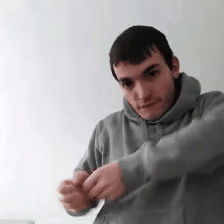

GT : S:bow : -0.6842710375785828 to 2.0
GT : S:arrow : 0.053420718759298325 to 2.0
Image:5 Gt:archery, 1st Pred:archery, 5.445, 2nd Pred:stretching arm, 5.124


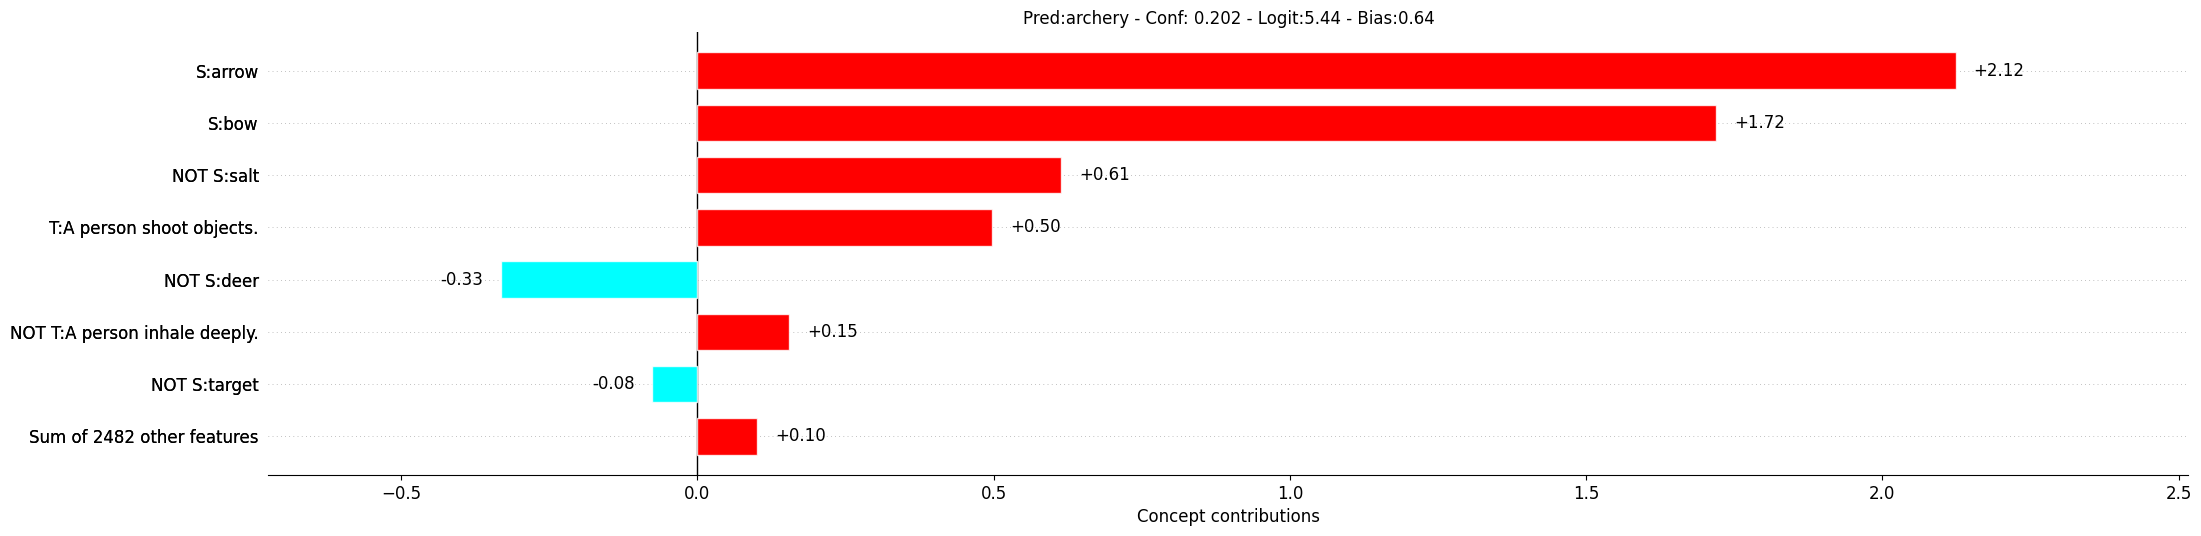

In [34]:
from torchvision.transforms import ToPILImage
from IPython.display import display, HTML, Video
# to_display = random.sample([i for i in range(len(val_pil_data))], k=20)

################
to_display =[5] # 이 샘플에 대한 컨셉 activation을 수정
act = 2.0
intervene_concepts = ['S:bow','S:arrow']
################

concept_idxs = []
for concept in intervene_concepts:
    if concept in concept_index:
        concept_idxs.append(concept_index[concept])
    else:
        print(f"Concept '{concept}' not found in the concept list.")

import matplotlib.pyplot as plt
to_pil_image = ToPILImage()

with torch.no_grad():
    for i in to_display:
        visual_index=2
        val_pil_data.end_point = visual_index
        image,label ,path= val_pil_data[i]
        x, _ ,_= val_data_t[i]
        x = x.unsqueeze(0).to(device)
        x=x[:,visual_index]
        visualize_gif(image,label ,path,visual_index,i)
        # image = to_pil_image(image)
        fig, axs = plt.subplots(1, 1, figsize=(5, 5))
        title_anno={'spatial':None,'temporal':None}
        # for j, context in enumerate(['spatial', 'temporal']):

        outputs, concept_act = model(x)
        concept_act = intervene_act(act, intervene_concepts, concept_idxs, concept_act)
        outputs = model.final(concept_act)
        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)   
        title_anno['spatial']="Image:{} Gt:{}, 1st Pred:{}, {:.3f}, 2nd Pred:{}, {:.3f}".format(i, classes[int(label)], classes[top_classes[0]], top_logit_vals[0],
                                                                    classes[top_classes[1]], top_logit_vals[1])
        
        for k in range(1):  
            contributions = concept_act[0]*model.final.weight[top_classes[k], :]
            feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
            values = contributions.cpu().numpy()
            max_display = min(int(sum(abs(values)>0.005))+1, 8)
            title = "Pred:{} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(classes[top_classes[k]],
                            conf[top_classes[k]], top_logit_vals[k], model.final.bias[top_classes[k]])
            # plt.sca(axs[0])
            plots.bar(values, feature_names, max_display=max_display, show=False,title=title, fontsize=12, pos_color=(1, 0, 0))
            # plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=16,pos_color=(1,0,0) if context=='spatial' else (0,0,1))
        # plt.tight_layout(pad=40.0
        print(title_anno['spatial'],sep=' '*50)
        plt.subplots_adjust(left=0.1, right=2.5, top=0.85, bottom=0.1, wspace=0.4)
        plt.show()


In [26]:
model.final.weight[333,78:80]

tensor([0., 0.], device='cuda:0', grad_fn=<SliceBackward0>)

In [40]:
concept_act[0][79]

tensor(2., device='cuda:0')

In [42]:
contributions[79]

tensor(0., device='cuda:0')